Calculation of the Milky Way's rotation curve using the LSR system.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
coord.galactocentric_frame_defaults.set("latest")

<ScienceState galactocentric_frame_defaults: {'galcen_coord': <ICRS Coordinate: (ra, dec) in deg...>

For now, one target is only selected and the data are pulled from the SIMBAD database. The galactic coordinates are completely random.

In [ ]:
icrs=Table.read("your_file.csv", format="csv")

#exclude X lines
icrs=icrs[X:]

icrs['ra'].unit = u.deg
icrs['dec'].unit = u.deg
icrs['distance'].unit = u.lightyear
icrs['pm_dec'].unit = u.mas/u.yr
icrs['pm_ra'].unit = u.mas/u.yr
icrs['radial_valocity'].unit = u.km/u.s
coordinates = coord.SkyCoord(ra=icrs['ra'], dec=icrs['dec'], frame='icrs')

icrs['gal_l'] = coordinates.galactic.l
icrs['gal_b'] = coordinates.galactic.b




The properties of the Sun: its galactic longtitude, radial velocity, distance from the galactic center.

In [5]:
v_sun = coord.Galactocentric().galcen_v_sun.to_cartesian()
gal = icrs.transform_to(coord.Galactic)
gal_sun_v = v_sun.norm()
gal_sun_d = 8 * u.kpc
gal_sun_l = 0 * u.rad
print(gal_sun_v)

246.06157440770798 km / s


In [4]:
icrs1 = coord.SkyCoord(
    ra=89.014303 * u.degree,
    dec=13.924912 * u.degree,
    distance=(37.59 * u.mas).to(u.kpc, u.parallax()),
    pm_ra_cosdec=372.72 * u.mas / u.yr,
    pm_dec=-483.69 * u.mas / u.yr,
    radial_velocity=0.37 * u.km / u.s,
    frame="icrs",
)
gal_long=icrs1.galactic.l


Calculation of the total proper motion of the target and, then, its distance from the Sun

In [20]:
pm = np.sqrt(icrs1.pm_ra_cosdec**2 + icrs1.pm_dec**2).to(u.mas / u.yr)
d_target = icrs1.distance
print("distance to the Sun:",d_target)
print(pm)

distance to the Sun: 0.026602819898909284 kpc
610.6359099332433 mas / yr


Calculation of the target's distance from the galactic center.

In [21]:
r_target = np.sqrt(gal_sun_d**2 + d_target**2- (2 * gal_sun_d * d_target * np.cos(gal_long.to(u.rad).value))) 
print("radius to the galactic center:",d_target)


radius to the galactic center: 0.026602819898909284 kpc


Calculation of tangent velocity and the total velocity of the target.
Vobst = Vtangent = 4.76*μ*d,    
V_target = Vtotal = (R/R_sun)*((Vradial/sinl)+V_sun)

In [23]:
Vobst=(4.76 * pm *d_target)
V_target = (r_target / gal_sun_d) * ((icrs1.radial_velocity / np.sin(gal_long.to(u.rad))) + gal_sun_v) 

print("total velocity:",V_target, "radial velocity:",icrs.radial_velocity, "tangent velocity:",Vobst)

total velocity: 246.46645049081607 km / s radial velocity: 0.37 km / s tangent velocity: 77.32447276622074 kpc mas / yr


Error calculations. 
The formula ΔV=(dVur^2 + dVr^2)^(1/2), in which dVur: the error in radial velocity (μερική παράγωγος * σφάλμα) and dVr: the error in the radius to galactic center.
The formula for the ΔV:
ΔV = {[(R/R_sun*sinl)*dVur]^2 + [(s*Vtotal/R^2)*dVr]^2}^(1/2)
s=R - R_sun*cosl

In [29]:
dur = 5 *u.km/u.s
dr = 0.2 *u.kpc
error_radial = (r_target / (gal_sun_d * np.sin(gal_long.to(u.rad)))) * dur
error_gal_radius =np.abs( ((d_target - (gal_sun_d * np.cos(gal_long.to(u.rad).value))) * V_target / r_target**2) * dr)
error_velocity = np.sqrt(error_radial**2 + error_gal_radius**2)


Create Figure 1: the rotation curve of the Milky Way. Y-axis: total velocity km/s , X-axis: radius to galactic center kpc.

!!! Επειδή η είσοδος των δεδομένων δεν είναι έτοιμη, το παρακάτω διάγραμμα μόνο δουλευεί με τα παρακάτω ψεύτικα δεδομένα για να επιβεβαιωθεί η δομή του κώδικα για το polynomial fit. 

In [27]:
r_target2=[1,3,5,8,13,14,19]
V_target2=[200,230,240,220,240,250,240]
error_gal_radius2=[1,1,1,1,1,1,1]
error_velocity2=[10,10,10,10,10,10,10]

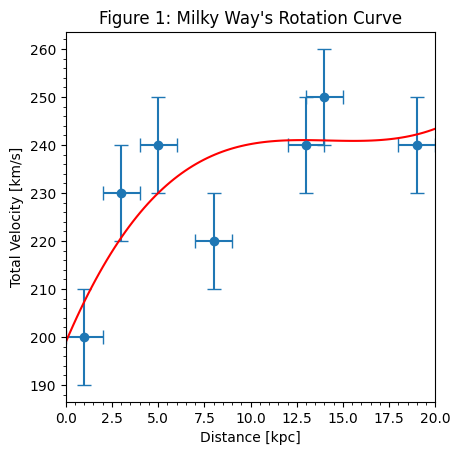

In [28]:
rot_curve = np.poly1d(np.polyfit(r_target2, V_target2, 3))
line_r_pol = np.linspace(0, 20, 100)

#the plots
plt.errorbar(r_target2,V_target2, xerr=error_gal_radius2, yerr=error_velocity2, fmt='o', capsize=5)
plt.plot(line_r_pol, rot_curve(line_r_pol), color="red")
plt.title("Figure 1: Milky Way's Rotation Curve")
ax1=plt.gca()
ax1.set_xlabel("Distance [kpc]")
ax1.set_xlim([0,20])
ax1.set_ylabel("Total Velocity [km/s]")
ax1.yaxis.get_ticklocs(minor=True)
ax1.xaxis.get_ticklocs(minor=True)
ax1.minorticks_on()
ax1.set_box_aspect(1.0)
plt.show()

Create Figure 2: Polar plot taht shows the position of the target in the Galaxy.

!!! Σε αυτό το διάγραμμα έχω βάλει το αρχικό target

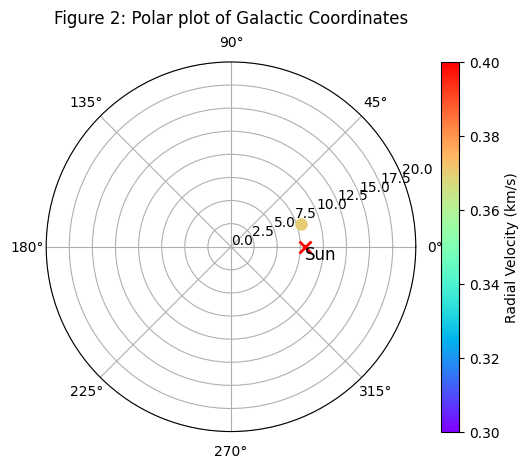

In [10]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

norm = plt.Normalize(0.3,0.4)
#norm = plt.Normalize(np.min(icrs.radial_velocity), np.max(icrs.radial_velocity))

color = cm.rainbow(norm(icrs1.radial_velocity.value))  

ax.plot(gal_long.to(u.rad).value, r_target.value, 'o', color=color, markersize=8)
ax.plot(gal_sun_l, gal_sun_d,'x', color="red", markersize=8,markeredgewidth=2)
plt.text(gal_sun_l.value -0.1, gal_sun_d.value, "Sun", fontsize=12,verticalalignment='center')
ax.set_title('Figure 2: Polar plot of Galactic Coordinates', va='bottom')
custom_radii = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]
ax.set_rticks(custom_radii)

sm = plt.cm.ScalarMappable(cmap=cm.rainbow, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Radial Velocity (km/s)')


plt.show()